In [2]:
# Initial imports
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Load the ventas_linea.csv dataset.
ventas_df = pd.read_csv('./almacenes_ventas.csv')
ventas_df

,product_id,description,date,name,qty,price_unit
0,26078,XIAOMI REDMI-NOTE-11S 6/128 NGO,24/02/2023,ALLENDE (QRO),1,4568.110000
1,26579,MOTO G41 4/128 DORADO,24/02/2023,ALLENDE (QRO),1,3620.680000
2,26579,MOTO G41 4/128 DORADO,24/02/2023,ALLENDE (QRO),1,3619.827500
3,26585,MOTO G22 4/128 NEGRO,24/02/2023,PLAZA MAYOR (LEON),1,3878.450000
4,25565,MOTO G60S 6/128 AZUL,24/02/2023,MADERO (LEON),1,4481.896552
...,...,...,...,...,...,...
34097,26053,ZTE L8 1/32 NEGRO,24/02/2023,CORREGIDORA 3 (QRO),1,1033.620000
34098,31000,APPLE IPHONE-11 4/64 BLANCO KIT,24/02/2023,PLAZA PATIO (QRO),1,9481.900000
34099,26578,MOTO G41 4/128 NEGRO,24/02/2023,ALLENDE (QRO),1,3275.000000
34100,25533,MOTO E20 2/32 AZUL,24/02/2023,PLAZA PATIO (QRO),1,1723.280000


In [4]:
# Convert the date column to datetime and set it as the index
ventas_df['date'] = pd.to_datetime(ventas_df['date'])
ventas_df.set_index('date', inplace=True)

# Split the 'description' column into multiple columns
ventas_df[['brand', 'model', 'details']] = ventas_df['description'].str.split(' ', n=2, expand=True)

# Compute the total sales column
ventas_df['total_sales'] = ventas_df['qty'] * ventas_df['price_unit']

# Group the data frame by name and month, and sum the qty and total sales columns
final_ventas_df = ventas_df.groupby([pd.Grouper(freq='M'), 'name', 'brand']).agg({'qty': 'sum', 'price_unit':'mean', 'total_sales': 'sum'})

# Reset the index to make the month, name, and description columns
final_ventas_df = final_ventas_df.reset_index()

# Format the month column as month names
final_ventas_df['date'] = final_ventas_df['date'].dt.strftime('%B')

# Rename the columns
final_ventas_df = final_ventas_df.rename(columns={'date': 'month'})

# Set the display option to show numbers without scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# Print the summary data frame
final_ventas_df = final_ventas_df[['name', 'brand', 'month', 'qty', 'price_unit', 'total_sales']].sort_values('qty', ascending=False)
final_ventas_df

,name,brand,month,qty,price_unit,total_sales
3280,ALLENDE (QRO),SAM,December,203,"3,621.86","735,238.38"
3472,LEON CENTRO (LEON),SAM,December,172,"3,021.68","519,728.59"
2949,ALLENDE (QRO),SAM,November,170,"3,777.76","644,905.41"
2644,ALLENDE (QRO),SAM,October,143,"3,588.01","513,084.77"
2016,ALLENDE (QRO),SAM,August,143,"4,211.86","602,295.94"
...,...,...,...,...,...,...
1513,HIDALGO 2 (CELAYA),LANIX,June,1,"1,723.28","1,723.28"
3834,PARQUE (QRO),HISENSE,January,1,"3,102.59","3,102.59"
1517,HIDALGO 2 (CELAYA),SENWA,June,1,568.10,568.10
1518,HIDALGO 2 (CELAYA),XIAOMI,June,1,"4,137.07","4,137.07"


In [5]:
# Define a list of words that represent devices
accesories_words = ['ROUTER']

# Check which rows contain any of the accesories-related words
is_device = final_ventas_df['brand'].str.contains('|'.join(accesories_words))

# Invert the boolean values to select only the rows where no accesories-related words are present
final_ventas_devices_df = final_ventas_df[~is_device]
final_ventas_devices_df.head(20)

,name,brand,month,qty,price_unit,total_sales
3280,ALLENDE (QRO),SAM,December,203,"3,621.86","735,238.38"
3472,LEON CENTRO (LEON),SAM,December,172,"3,021.68","519,728.59"
2949,ALLENDE (QRO),SAM,November,170,"3,777.76","644,905.41"
2644,ALLENDE (QRO),SAM,October,143,"3,588.01","513,084.77"
2016,ALLENDE (QRO),SAM,August,143,"4,211.86","602,295.94"
767,CORREGIDORA 2 (QRO),SAM,April,128,"4,416.04","565,252.65"
1027,ALLENDE (QRO),SAM,May,128,"4,558.18","583,446.53"
2342,ALLENDE (QRO),SAM,September,127,"4,084.88","518,779.58"
1748,CORREGIDORA 2 (QRO),SAM,July,120,"4,241.14","508,937.15"
3284,ALLENDE (QRO),XIAOMI,December,120,"2,555.20","304,989.91"


In [6]:
final_ventas_df = pd.get_dummies(final_ventas_df, columns=['name', 'brand', 'month'])
final_ventas_df

,qty,price_unit,total_sales,name_ALAMEDA (QRO),name_ALLENDE (CELAYA),name_ALLENDE (QRO),name_ANDADOR (CELAYA),name_ANTEA (QRO),name_BOULEVARES (QRO),name_CONSTITUYENTES (QRO),...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
3280,203,"3,621.86","735,238.38",0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3472,172,"3,021.68","519,728.59",0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2949,170,"3,777.76","644,905.41",0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2644,143,"3,588.01","513,084.77",0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2016,143,"4,211.86","602,295.94",0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,1,"1,723.28","1,723.28",0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3834,1,"3,102.59","3,102.59",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1517,1,568.10,568.10,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1518,1,"4,137.07","4,137.07",0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
# splitting the DataFrame
X = final_ventas_df.drop(columns='qty')
y = pd.DataFrame(final_ventas_df['qty'])
y = y.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')


In [8]:
y

,qty
0,203
1,172
2,170
3,143
4,143
...,...
5315,1
5316,1
5317,1
5318,1


In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
   y, random_state=1)

In [123]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [124]:
model.fit(X_train, y_train)

LinearRegression()

In [133]:
y_pred = model.predict(X)
print(y_pred.shape)
df = pd.DataFrame(y_pred)
df_joint = pd.concat([df, y], axis=1)
df_joint['index'] = df_joint.index
df_joint

(5320, 1)


,0,qty,index
0,189.87,203,0
1,133.91,172,1
2,165.81,170,2
3,132.51,143,3
4,154.58,143,4
...,...,...,...
5315,1.10,1,5315
5316,1.12,1,5316
5317,1.46,1,5317
5318,1.44,1,5318


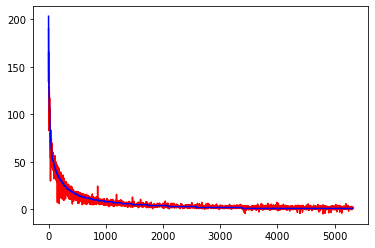

In [139]:
plt.plot(df_joint['index'], y_pred, color='red')
plt.plot(df_joint['index'], y, color='blue')
plt.show()

[[-7.15136036e-04  2.52989410e-04  9.88241674e-02 -1.22342043e-01
   2.78864151e+00  3.10969980e-02 -4.84379063e-01 -3.17819157e-01
  -3.47326000e-01  1.57934886e-01  7.66448906e-01  1.88166188e-01
   6.08487181e-01 -3.27079890e-01  7.21658931e-01  2.00590805e-01
  -1.38205750e-01 -4.04351354e-01 -6.25031977e-01  9.27816829e-01
   1.29303658e-01 -3.83954952e-01 -3.53841640e-01 -8.10418946e-02
  -2.91425486e-01 -1.93730184e-01 -1.03630264e-01  1.12331650e-01
  -4.13880153e-01 -4.59193087e-01 -9.44301467e-01 -7.39767349e-01
  -1.05305149e+00 -1.10698682e+00 -6.55813686e-01  4.09124213e+00
   1.38767057e+00 -1.27656380e+00  1.36002321e-15 -8.01523440e-01
  -1.94523417e+00  4.49208972e-01  3.43364746e-01  2.49845623e-01
  -1.06333049e+00 -7.69720915e-01 -1.55342965e-01 -2.81647733e-01
   6.57089377e-01  3.93891196e-01  5.74097749e-01  7.47902753e-01
   7.43161095e-01  4.43895990e-01 -4.43166302e-01 -7.23307811e-01
   1.79049755e-01  1.14247365e-01 -4.54514656e-01 -5.96218897e-01
  -1.73235

In [10]:
# Logistic Regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
    y, random_state=1)

In [18]:
from sklearn.linear_model import LogisticRegression
LogisticR = LogisticRegression(solver='newton-cg', random_state=1)
LogisticR

LogisticRegression(random_state=1, solver='newton-cg')

In [19]:
LogisticR.fit(X_train, y_train)

C:\Users\Jp\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Jp\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


LogisticRegression(random_state=1, solver='newton-cg')

In [23]:
predictions = LogisticR.predict(X)
print(predictions.shape)
df = pd.DataFrame(predictions)
df_joint = pd.concat([df, y], axis=1)
df_joint['index'] = df_joint.index
df_joint.head(50)

(5320,)


,0,qty,index
0,203,203,0
1,170,172,1
2,170,170,2
3,128,143,3
4,128,143,4
5,128,128,5
6,128,128,6
7,128,127,7
8,120,120,8
9,120,120,9


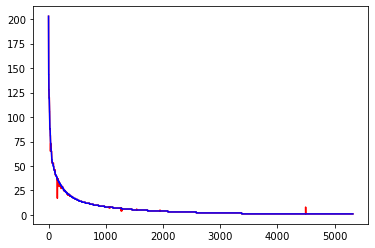

In [24]:
plt.plot(df_joint['index'], predictions, color='red')
plt.plot(df_joint['index'], y, color='blue')
plt.show()

In [ ]:
import tkinter as tk

# Create the main window
root = tk.Tk()

# Create a list of options for the dropdown
options = ['Option 1', 'Option 2', 'Option 3']

# Create a variable to store the selected option
selected_option = tk.StringVar()

# Set the default option
selected_option.set(options[0])

# Create the dropdown menu
dropdown = tk.OptionMenu(root, selected_option, *options)
dropdown.pack()

# Run the main event loop
root.mainloop()

In [1]:
from ipywidgets import interact

In [7]:
def store(Store): 
    return

interact(store, Store=[ 'name_ALAMEDA (QRO)',
    'name_ALLENDE (CELAYA)',
    'name_ALLENDE (QRO)',
    'name_ANDADOR (CELAYA)',
    'name_ANTEA (QRO)',
    'name_BOULEVARES (QRO)',
    'name_CONSTITUYENTES (QRO)',
    'name_CORREGIDORA 2 (QRO)',
    'name_CORREGIDORA 3 (QRO)',
    'name_CORREGIDORA 4 (QRO)',
    'name_FIESTA (IRAPUATO)',
    'name_GALERIAS (QRO)',
    'name_GUERRERO (QRO)',
    'name_HIDALGO (CELAYA)',
    'name_HIDALGO 2 (CELAYA)',
    'name_LA CRUZ (QRO)',
    'name_LA VICTORIA (QRO)',
    'name_LEON CENTRO (LEON)',
    'name_MADERO (LEON)',
    'name_MADERO (QRO)',
    'name_MAYOREO (QRO)',
    'name_OBREGON (LEON)',
    'name_PARQUE (CELAYA)',
    'name_PARQUE (QRO)',
    'name_PLAZA MAYOR (LEON)',
    'name_PLAZA PATIO (QRO)',
    'name_PORTAL (QRO)',
    'name_URBAN (QRO)',
    'name_VALLARTA (VTA)',
    'name_VIA ALTA SUR (LEON)'])

interactive(children=(Dropdown(description='Store', options=('name_ALAMEDA (QRO)', 'name_ALLENDE (CELAYA)', 'n…

<function __main__.store(Store)>

In [8]:
import ipywidgets as widgets

# Define a list of options for the dropdown
options = ['Option 1', 'Option 2', 'Option 3']

# Create a dropdown widget
dropdown = widgets.Dropdown(options=options, description='Select an option:', value='Option 1')

# Define a function to be called when the dropdown value changes
def on_dropdown_change(change):
    input_text.value = change.new

# Attach the function to the dropdown widget
dropdown.observe(on_dropdown_change, names='value')

# Create a text input widget
input_text = widgets.Text(value='Option 1', description='Selected option:')

# Display the widgets
display(dropdown)
display(input_text)

Dropdown(description='Select an option:', options=('Option 1', 'Option 2', 'Option 3'), value='Option 1')

Text(value='Option 1', description='Selected option:')